###### Moises Quiroz Diaz

Modelo implementado con SVM para clasificar la calidad de un conjuto de datos sobre vinos

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lec5_graphs as afx

warnings.simplefilter('ignore')
plt.rcParams['figure.figsize'] = (10,6)
plt.style.use('seaborn')

In [2]:
df = pd.read_csv('winequality_merged.csv').drop(columns ='Unnamed: 0')
df.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Se procede a realizar una serie de graficos para ver la distribucion de cada variable y a su vez corroborar si es un dato continuo o discreto

In [3]:
rows = 4 ; cols = df.shape[1]/rows

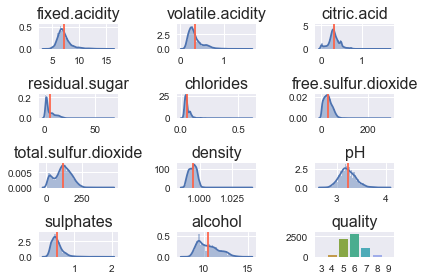

In [4]:
for index,(colname,serie) in enumerate(df.iteritems()):
    plt.subplot(rows,cols,index+1)
    if pd.api.types.is_float_dtype(serie) is True:
        sns.distplot(serie)
        plt.axvline(np.mean(serie),color='tomato')
    elif pd.api.types.is_integer_dtype(serie) is True:
        sns.countplot(serie)
    plt.title(colname,fontsize=16)
    plt.xlabel('');plt.ylabel('');plt.tight_layout()

Se observa que la mayoria de las variables presenta valores de promedio bajos y lo siguiente es realizar una binarizacion del vector objetivo 'quality'

In [5]:
df['quality_bin'] = np.where(df['quality']> np.mean(df['quality']),1,0)
df.quality_bin.value_counts('%').round(3)

1    0.633
0    0.367
Name: quality_bin, dtype: float64

Luego de este ver como es que se comporta el dataset, se procede a realizar un modelo de suport vector machine para clasificacion

In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,classification_report

In [7]:
df = df.drop(columns = 'quality')

In [8]:
X_train,X_test, y_train , y_test = train_test_split(df[df.columns[:-1]],df['quality_bin'],test_size=.33,random_state=11238)

In [9]:
X_std = StandardScaler().fit_transform(X_train)

In [10]:
wine_svc = Pipeline(
    [
        ('scaler',StandardScaler()) ,
        ('svc',SVC(kernel='linear'))
]
)

In [11]:
wine_svc.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [12]:
y_hat= wine_svc.predict(X_test)

In [15]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.70      0.56      0.62       815
           1       0.76      0.85      0.80      1330

    accuracy                           0.74      2145
   macro avg       0.73      0.71      0.71      2145
weighted avg       0.74      0.74      0.74      2145



In [16]:
wine_svc_rbf = Pipeline(
[
    ('scaler',StandardScaler()),
    ('svc',SVC(kernel='rbf'))
])

In [17]:
wine_svc_rbf.fit(X_train,y_train)

y_hat_rbf = wine_svc_rbf.predict(X_test)
print(classification_report(y_test,y_hat_rbf))

              precision    recall  f1-score   support

           0       0.73      0.62      0.67       815
           1       0.79      0.86      0.82      1330

    accuracy                           0.77      2145
   macro avg       0.76      0.74      0.74      2145
weighted avg       0.76      0.77      0.76      2145



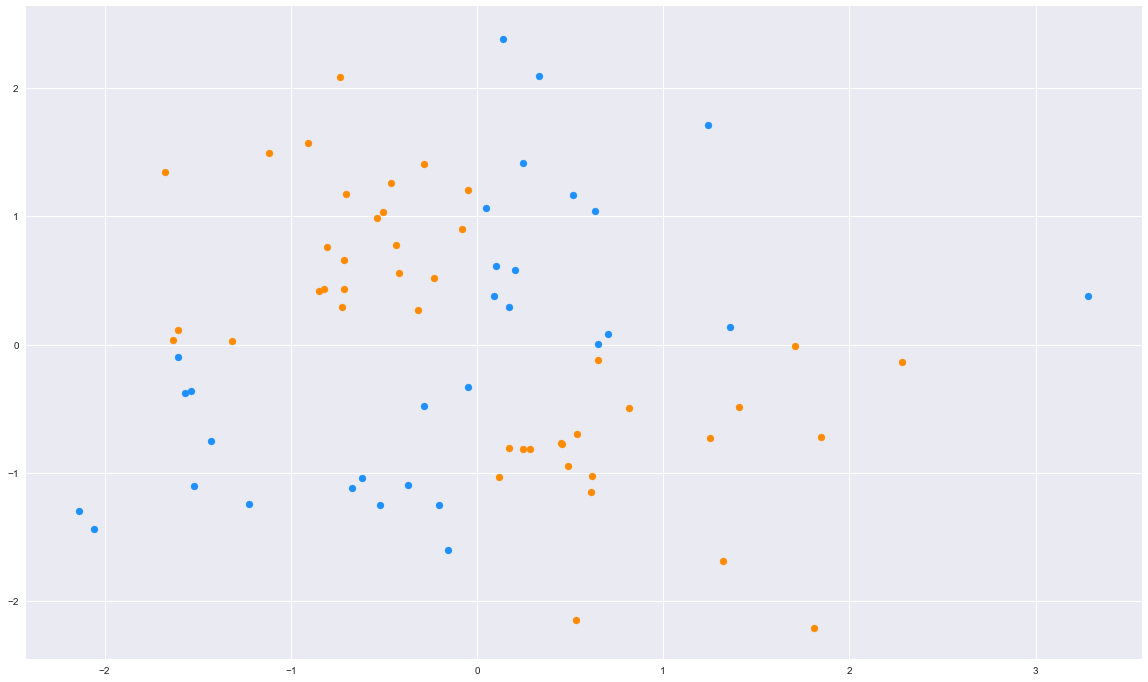

In [22]:
X,y = afx.svm_logical_xor_data(nsize=75)
plt.figure(figsize=(20,12))
plt.scatter(X[y==1][:,0],X[y==1][:,1],color = 'darkorange')
plt.scatter(X[y==-1][:,0],X[y==-1][:,1],color = 'dodgerblue')

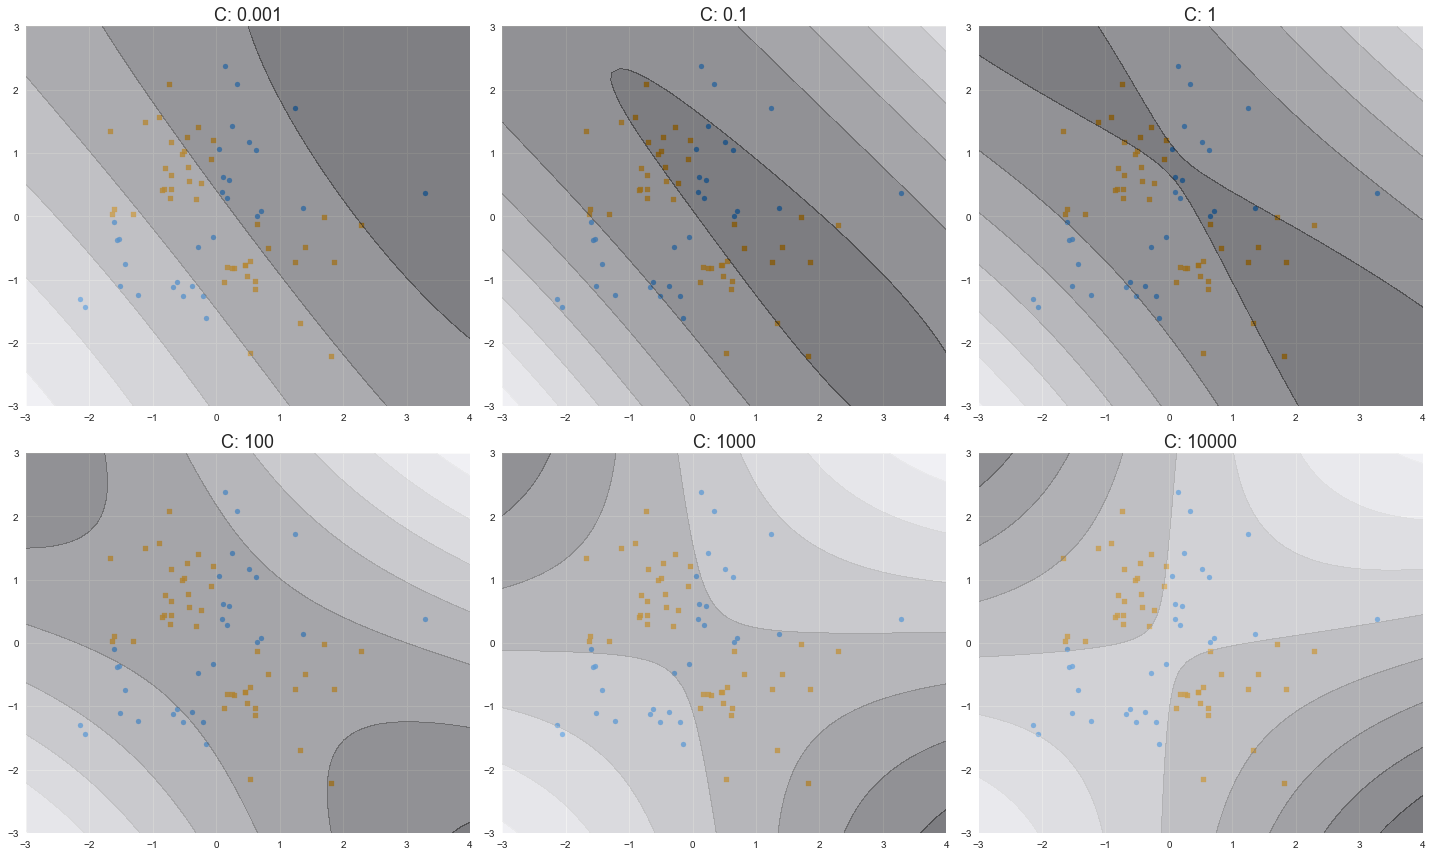

In [23]:
X,y = afx.svm_logical_xor_data(nsize=75)
plt.figure(figsize=(20,12))
afx.svm_c_hyperparameter(X,y,c_range=[0.001,0.1,1,100,1000,10000])

Aqui se observa que a medida que el costo aumenta, el modelo intanta cada vez mas ajustarse a los datos, produciendo overfitting

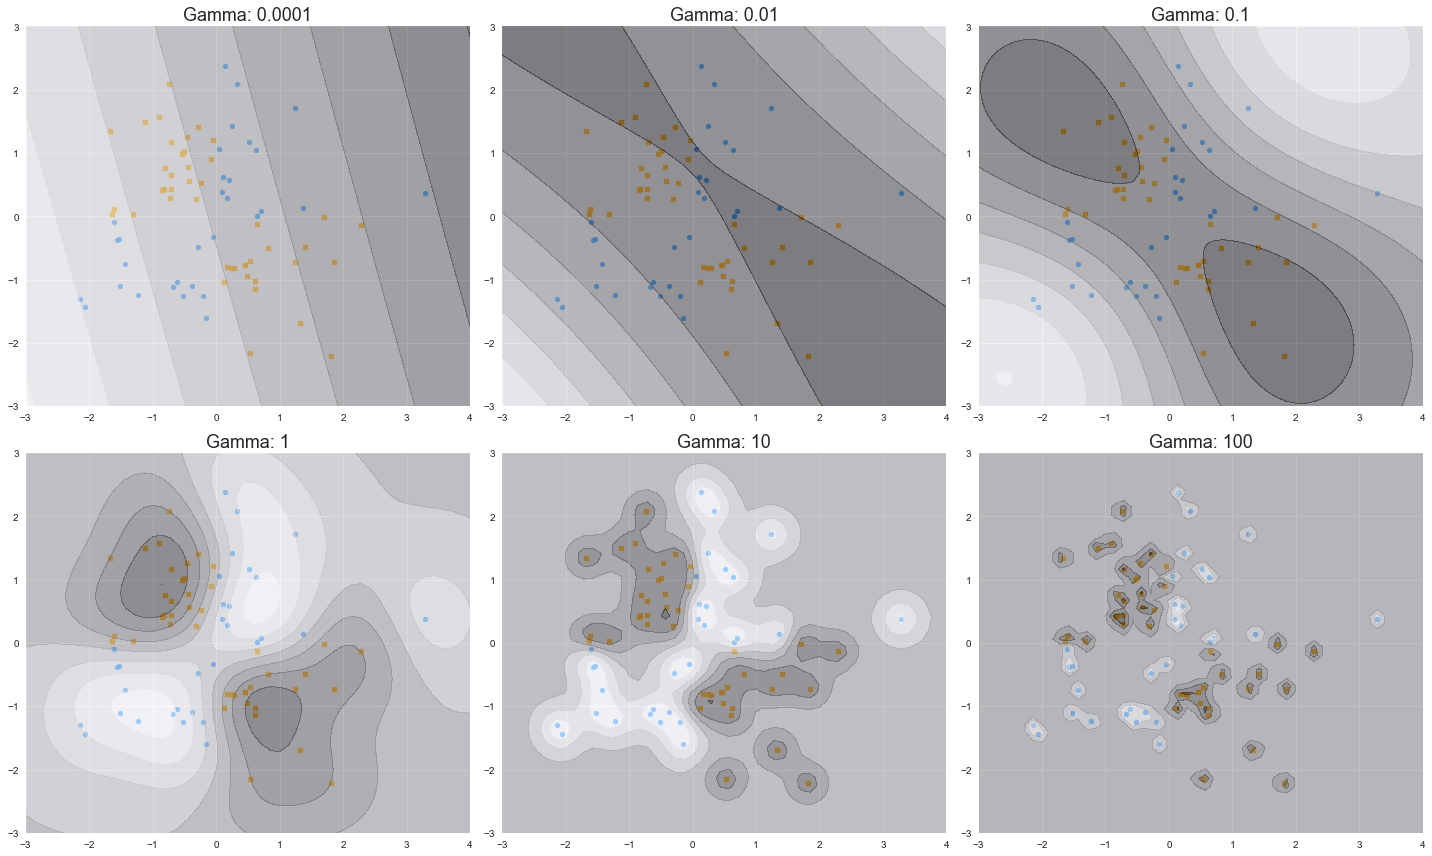

In [24]:
X,y = afx.svm_logical_xor_data(nsize=75)
plt.figure(figsize=(20,12))
afx.svm_gamma_hyperparameter(X,y,gamma_range=[0.0001,0.01,0.1,1,10,100])

##### Busqueda de grilla para hiperparametros

In [25]:
X_scaled = StandardScaler().fit_transform(df.loc[:,'fixed.acidity':'alcohol'])
X_train,X_test, y_train,y_test = train_test_split(X_scaled,df['quality_bin'],random_state= 11238,test_size=.33)

In [27]:
c_param_range=[0.001,0.1,1,100,1000,10000]
gamma_param_range=[0.0001,0.01,0.1,1,10,100]

from sklearn.model_selection import cross_val_score

In [28]:
empty_dict={}
best_score = 0

c_holder = []
for c in c_param_range:
    gamma_holder = []
    for gamma in gamma_param_range:
        tmp_score = cross_val_score(SVC(C=c,gamma= gamma),
                                   X_train,y_train,cv = 5)
        empty_dict[str("C:{}, gamma:{}".format(c,gamma))]= list(tmp_score)
        gamma_holder.append(np.mean(tmp_score))
        if np.mean(tmp_score)> best_score:
            best_score= np.mean(tmp_score)
            best_params = str("C:{}, gamma:{}".format(c,gamma))
        
    c_holder.append(gamma_holder)
cv_params = np.array(c_holder).reshape(6,6)

In [30]:
cv_params

array([[0.63947617, 0.63947617, 0.63947617, 0.63947617, 0.63947617,
        0.63947617],
       [0.63947617, 0.70587682, 0.7483834 , 0.64521987, 0.63947617,
        0.63947617],
       [0.63947617, 0.74999867, 0.76952043, 0.76630838, 0.71392518,
        0.70634372],
       [0.74723794, 0.76285904, 0.76722158, 0.76171781, 0.71645419,
        0.70634372],
       [0.74930928, 0.76078347, 0.75573974, 0.76171781, 0.71645419,
        0.70634372],
       [0.75275544, 0.76491876, 0.74586365, 0.76171781, 0.71645419,
        0.70634372]])

In [31]:
best_score

0.7695204314677008

In [32]:
best_params

'C:1, gamma:0.1'

Text(0.5, 1.0, 'Best params: C:1, gamma:0.1')

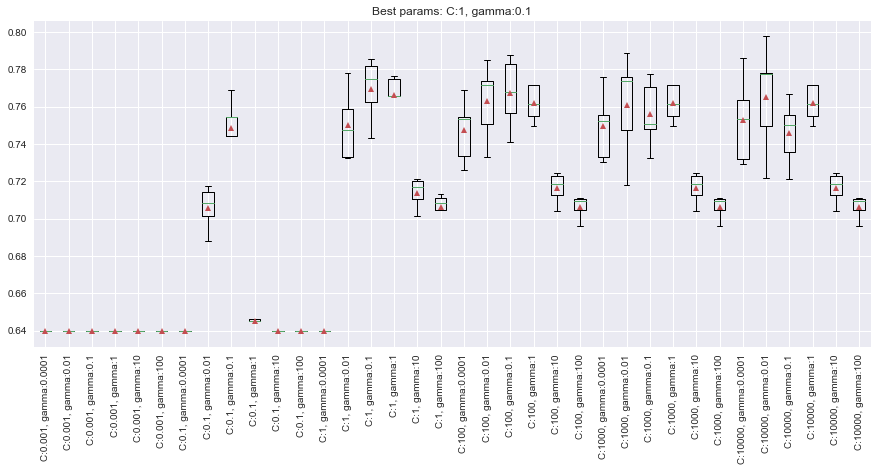

In [39]:
plt.figure(figsize=(15,6))
plt.boxplot(empty_dict.values(),showmeans=True);
plt.xticks(range(1,len(empty_dict.keys())+1),empty_dict.keys(),rotation=90);
plt.title('Best params: {}'.format(best_params))

Text(0.5, 1.0, 'Accuracy heatmap')

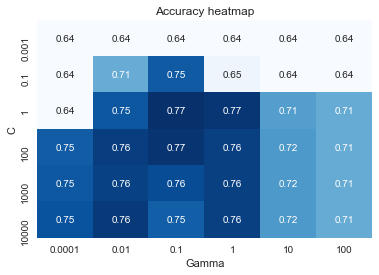

In [41]:
sns.heatmap(cv_params,annot=True,cmap='Blues',
           cbar=False,xticklabels=gamma_param_range,yticklabels=c_param_range)
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('Accuracy heatmap')

In [35]:
refactor_svc_rbf = Pipeline(
[
    ('scale',StandardScaler()),
    ('svc',SVC(kernel='rbf',C=1,gamma=0.1))
])

refactor_svc_rbf.fit(X_train,y_train)
y_hat = refactor_svc_rbf.predict(X_test)
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.73      0.62      0.67       815
           1       0.79      0.86      0.82      1330

    accuracy                           0.77      2145
   macro avg       0.76      0.74      0.75      2145
weighted avg       0.77      0.77      0.77      2145

